In [1]:
!pip install pot
!pip install ipdb #For debugging
!pip install tqdm #For the progress bar
!pip install numpy matplotlib tensorflow
!pip install jax jaxlib #Install jax and jaxlib, which stax depends on.
!pip install -U stax #Reinstall stax to ensure the latest version
!pip install --upgrade neural-tangents #Update neural-tangents

#Save requirements
#!pip freeze > requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 48.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 137.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 10.0 MB/s eta 0:00:00
  Created wheel for halo: filename=halo-0.0.31-py3-none-any.whl size=11232 sha256=3a959bb4177ef74a7260b6df08c0df81c136639f4ef9c9b0663a0872091f355f
  Stored in directory: /root/.cache/pip/wheels/0b/b2/f8/376708b4c66e68a1a7d40aaba26521645e7f5ad3b9ef756031
Successfully built halo
INFO: pip is looking at multiple versions of tf2jax to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.7/248.7 kB 18.6 M

This notebook tests how the 2-Wasserstein distance between wide neural networks (NNs) and Gaussian Processes (GPs) approximations of the NNs changes when the width of the networks diverges.
The output plot shows the 2-Wasserstein distance on the y-axis against the network width on the x-axis, both on a logarithmic scale.

**Parameters:**

*   `num_networks`: Number of parallel neural networks trained (also the batch size).
*   `num_gp_samples`: Number of samples drawn from the Gaussian Process. These two values need to coincide and account for the discrete approximation of the 2-Wasserstein distance via the pot package.
*   `n_train`: Size of the training dataset.
*   `num_test_inputs`: Number of test inputs.
*   `epochs`: Number of training epochs for the neural networks.
*   `learning_rate`: Base learning rate for training.
*   `activation_function`: The activation function used in the neural networks (e.g., 'relu', 'sigmoid', 'erf').
*   `network_widths`: A list of network widths for which the W2 distance is calculated.

Using device: cuda


NN widths:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/ot/lp/_network_simplex.py:574: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)
NN widths:  12%|█▎        | 1/8 [00:33<03:53, 33.40s/it]

Width: 2, Scaled lr: 0.0005 W2 Distance: 1.8078


NN widths:  25%|██▌       | 2/8 [00:58<02:50, 28.49s/it]

Width: 4, Scaled lr: 0.00025 W2 Distance: 1.0917


NN widths:  38%|███▊      | 3/8 [01:22<02:12, 26.51s/it]

Width: 8, Scaled lr: 0.000125 W2 Distance: 0.6383


NN widths:  50%|█████     | 4/8 [01:46<01:42, 25.64s/it]

Width: 16, Scaled lr: 6.25e-05 W2 Distance: 0.3623


NN widths:  62%|██████▎   | 5/8 [02:11<01:15, 25.20s/it]

Width: 32, Scaled lr: 3.125e-05 W2 Distance: 0.2952


NN widths:  75%|███████▌  | 6/8 [02:35<00:49, 24.92s/it]

Width: 64, Scaled lr: 1.5625e-05 W2 Distance: 0.2074


NN widths:  88%|████████▊ | 7/8 [03:00<00:24, 24.86s/it]

Width: 128, Scaled lr: 7.8125e-06 W2 Distance: 0.1887


NN widths: 100%|██████████| 8/8 [03:25<00:00, 25.69s/it]

Width: 256, Scaled lr: 3.90625e-06 W2 Distance: 0.1786
n_train=1, num_networks=10000, num_gp_samples=10000
num_test_inputs=1, epochs=1000, lr=0.001, activation=relu


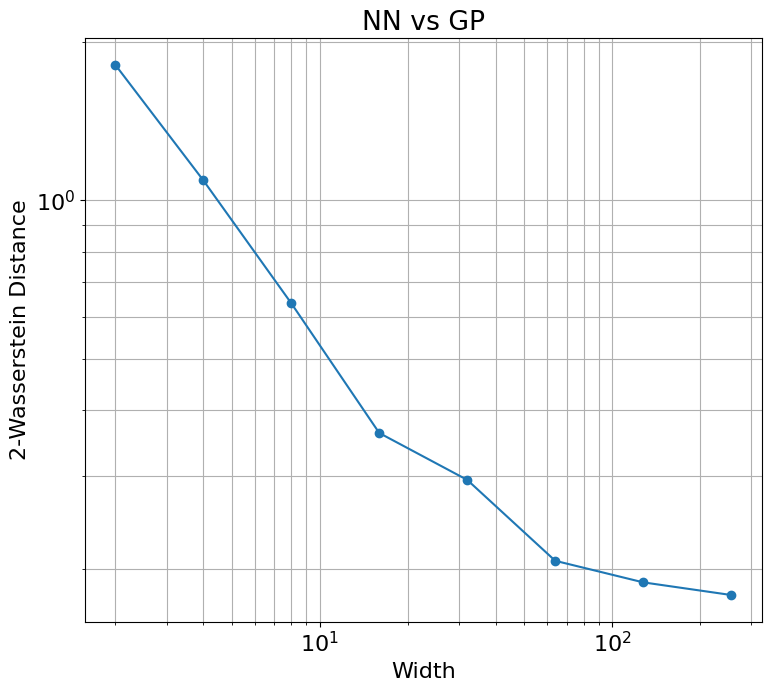

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import ot
import matplotlib.pyplot as plt
import scipy.linalg
import ipdb

import jax.numpy as jnp
import neural_tangents as nt
from neural_tangents import stax

from tqdm import tqdm

# --- PyTorch Device Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Simulation parameters ---
num_networks = 10000  # Number of networks for empirical W2 (becomes batch size for PyTorch model)
num_gp_samples = 10000

# --- Training set, labels and test set ---
num_test_inputs = 1
n_train = 1
x_train_np = np.array([[1]], dtype=np.float32)
y_train_np = np.array([[2]], dtype=np.float32)
x_test_np = np.array([[2]], dtype=np.float32)

# --- Epochs, learning rate, activation, array of widths to test ---
epochs = 1000  # Set to > 0 for actual training
learning_rate = 0.001
activation_function = 'relu'
network_widths = [2, 4, 8, 16, 32, 64, 128, 256]
scaled_lrs = learning_rate / np.array(network_widths) #Scaling as in [Lee et al. '19, Appendix F]

# --- PyTorch Batched Shallow NN ---
class BatchedShallowNN_Pytorch(nn.Module):
    def __init__(self, input_dim, hidden_units, num_parallel_networks, bias=False):
        super(BatchedShallowNN_Pytorch, self).__init__()
        self.num_parallel_networks = num_parallel_networks
        self.hidden_units = hidden_units
        # NTK Scaling factor
        self.ntk_scale = torch.sqrt(torch.tensor(hidden_units, dtype=torch.float32))

        # Set W_std and B_std based on the bias flag
        W_std = 1.0
        B_std = 1.0 if bias else 0.0

        # Parameters will have an extra dimension for num_parallel_networks
        # Layer 1 weights and biases
        self.w1 = nn.Parameter(torch.randn(num_parallel_networks, hidden_units, input_dim) * W_std)
        self.b1 = nn.Parameter(torch.randn(num_parallel_networks, hidden_units) * B_std)

        # Layer 2 weights and biases
        self.w2 = nn.Parameter(torch.randn(num_parallel_networks, 1, hidden_units) * W_std)
        self.b2 = nn.Parameter(torch.randn(num_parallel_networks, 1) * B_std)

        # Activation function selection
        if activation_function == 'sigmoid':
            self.activation = nn.Sigmoid()
        elif activation_function == 'relu':
            self.activation = nn.ReLU()
        elif activation_function == 'erf':
            self.activation = torch.erf

    def forward(self, x):
        # x has shape (batch_size_data, input_dim)
        # We want to process it with num_parallel_networks sets of weights

        # Expand x for batched matrix multiplication
        hidden_lin = torch.einsum('nhd,bd->nhb', self.w1, x) + self.b1.unsqueeze(2)
        hidden_act = self.activation(hidden_lin)

        # Output layer computation
        outputs_lin = torch.einsum('noh,nhb->nob', self.w2, hidden_act) + self.b2.unsqueeze(2)

        # NTK Scaling
        outputs_scaled = outputs_lin / self.ntk_scale

        # Reshape to (num_parallel_networks, batch_size_data, output_dim)
        return outputs_scaled.transpose(1, 2)

# --- Train Batched PyTorch Networks ---
def train_batched_networks_pytorch(width, num_parallel_train_networks,
                                   x_train_np_local, y_train_np_local, x_test_np_local,
                                   epochs_local, lr_local, current_device, bias=False):

    model = BatchedShallowNN_Pytorch(input_dim=x_train_np_local.shape[1],
                                     hidden_units=width,
                                     num_parallel_networks=num_parallel_train_networks,
                                     bias=bias).to(current_device)

    x_train_torch = torch.from_numpy(x_train_np_local).float().to(current_device)
    y_train_torch = torch.from_numpy(y_train_np_local).float().to(current_device)
    x_test_torch = torch.from_numpy(x_test_np_local).float().to(current_device)

    if epochs_local > 0:
        optimizer = optim.SGD(model.parameters(), lr=lr_local)
        criterion = nn.MSELoss()

        # Expand y_train to match batched output shape
        y_train_expanded = y_train_torch.unsqueeze(0).expand(num_parallel_train_networks, -1, -1)

        model.train()
        for epoch_idx in range(epochs_local):
            optimizer.zero_grad()
            outputs = model(x_train_torch)
            loss = criterion(outputs, y_train_expanded)
            loss.backward()
            optimizer.step()

    # Get predictions
    model.eval()
    with torch.no_grad():
        predictions_batched = model(x_test_torch)

    # Return as numpy array, flatten last two dims if output_dim is 1
    return predictions_batched.cpu().numpy().reshape(num_parallel_train_networks, -1)

# --- It function (RECEIVES TIME ALREADY SCALED t = t*scaled_lr) ---
def It(k, t):
    # Add a small diagonal jitter to handle singularity
    k_reg = k + np.eye(k.shape[0]) * 1e-6

    # Solve linear system kX = I - e^{-kt}
    b_matrix = np.identity(k_reg.shape[0]) - scipy.linalg.expm(-k_reg * t)
    return np.linalg.solve(k_reg, b_matrix)

# --- GP Calculation (RECEIVES TIME ALREADY SCALED t = t*scaled_lr) ---
def GPcharacterization(time,x_train,x_test,y_train):
    # First create kernels
    # Select activation function for NTK computation
    if activation_function == 'sigmoid':
        init_fn, apply_fn, kernel_fn = stax.serial(
            stax.Dense(10, W_std=1.0, b_std=0.0), stax.Sigmoid_like(),
            stax.Dense(1, W_std=1.0, b_std=0.0)
        )
    elif activation_function == 'relu':
        init_fn, apply_fn, kernel_fn = stax.serial(
            stax.Dense(10, W_std=1.0, b_std=0.0), stax.Relu(),
            stax.Dense(1, W_std=1.0, b_std=0.0)
        )
    elif activation_function == 'erf':
        init_fn, apply_fn, kernel_fn = stax.serial(
            stax.Dense(10, W_std=1.0, b_std=0.0), stax.Erf(),
            stax.Dense(1, W_std=1.0, b_std=0.0)
        )

    # Convert JAX arrays to NumPy for subsequent scipy/numpy operations
    k2_test_test_jax = kernel_fn(x_test, x_test, 'nngp')
    k2_test_train_jax = kernel_fn(x_test, x_train, 'nngp')
    k2_train_test_jax = kernel_fn(x_train, x_test, 'nngp')
    k2_train_train_jax = kernel_fn(x_train, x_train, 'nngp')

    kinf_test_train_jax = kernel_fn(x_test, x_train, 'ntk')
    kinf_train_train_jax = kernel_fn(x_train, x_train, 'ntk')

    # Convert JAX arrays to NumPy. .block_until_ready() is good practice for JAX before conversion.
    k2_test_test = np.array(k2_test_test_jax.block_until_ready())
    k2_test_train = np.array(k2_test_train_jax.block_until_ready())
    k2_train_test = np.array(k2_train_test_jax.block_until_ready())
    k2_train_train = np.array(k2_train_train_jax.block_until_ready())

    kinf_test_train = np.array(kinf_test_train_jax.block_until_ready())
    kinf_train_train = np.array(kinf_train_train_jax.block_until_ready())
    kinf_train_test = kinf_test_train.T

    # GP mean and covariance calculation
    if epochs == 0: # At initialization
        gp_mean = np.zeros_like(x_test @ y_train.T)
        gp_cov = k2_test_test
    else: # epochs > 0
        Itk = It(kinf_train_train, time)
        gp_mean = kinf_test_train @ Itk @ y_train

        pz1 = k2_test_test
        pz2 = -k2_test_train @ Itk @ kinf_train_test
        pz3 = -kinf_test_train @ Itk @ k2_train_test
        pz4 = +kinf_test_train @ Itk @ k2_train_train @ Itk @ kinf_train_test
        gp_cov = pz1 + pz2 + pz3 + pz4

    # Ensure gp_cov is positive semi-definite for sampling
    gp_cov = gp_cov + np.eye(gp_cov.shape[0]) * 1e-5

    return gp_mean, gp_cov

# --- Function to calculate W2 distance for a given network width ---
def calculate_w2_distance_pytorch(network_width_local, lr_local):
    # Train/evaluate batched networks and get dynamic learning rates
    nn_outputs = train_batched_networks_pytorch(
        width=network_width_local,
        num_parallel_train_networks=num_networks,
        x_train_np_local=x_train_np,
        y_train_np_local=y_train_np,
        x_test_np_local=x_test_np,
        epochs_local=epochs,
        lr_local=lr_local,
        current_device=device,
        bias=True
    )
    # nn_outputs shape: (num_networks, num_test_inputs)
    time = epochs*lr_local

    # Calculate GP mean and covariance
    gp_mean, gp_cov = GPcharacterization(time,x_train_np,x_test_np,y_train_np)

    # Sample the GP
    # gp_mean.flatten() because multivariate_normal expects 1D mean
    if gp_mean.ndim > 1 and gp_mean.shape[0] == num_test_inputs and gp_mean.shape[1] == 1 :
        gp_mean_flat = gp_mean.flatten()
    else:
        gp_mean_flat = gp_mean

    if num_test_inputs == 1 and gp_cov.ndim == 2 and gp_cov.shape == (1,1):
        # Special case for scalar output: multivariate_normal needs mean as (1,) and cov as (1,1)
        # If gp_cov is scalar, reshape
        gp_samples = np.random.normal(gp_mean_flat[0], np.sqrt(gp_cov[0,0]), size=(num_gp_samples, 1))
    elif num_test_inputs > 0 :
         gp_samples = np.random.multivariate_normal(gp_mean_flat, gp_cov, size=num_gp_samples)
         if num_test_inputs == 1 and gp_samples.ndim == 1: # If only one test input, result is (num_gp_samples,)
            gp_samples = gp_samples.reshape(-1,1) # Reshape to (num_gp_samples, 1)
    else: # num_test_inputs == 0, should not happen with valid x_test
        gp_samples = np.array([]).reshape(num_gp_samples,0)

    # Compute W2 distance between NN and GP using POT
    if num_test_inputs == 0:
        return 0.0 # Or handle as an error/special case

    a = np.ones((num_networks,)) / num_networks
    b = np.ones((num_gp_samples,)) / num_gp_samples

    cost_matrix = ot.dist(nn_outputs, gp_samples, metric='sqeuclidean') # POT uses squared Euclidean for W2^2
    W2_squared = ot.emd2(a, b, cost_matrix,numItermax=200000)

    if W2_squared < 0: # Numerical precision might lead to tiny negative
        print(f"Warning: W2_squared is {W2_squared}, clamping to 0.")
        W2_squared = 0.0
    W2 = np.sqrt(W2_squared)

    return W2

# --- Main Loop ---
# Train and calculate W2 distance with chosen activation
w2_distances = []
for i, width_val in tqdm(enumerate(network_widths), total=len(network_widths), desc="NN widths"):
    lr_val = scaled_lrs[i]
    w2_dist = calculate_w2_distance_pytorch(width_val,lr_val)
    w2_distances.append(w2_dist)
    print(f"Width: {width_val}, Scaled lr: {lr_val} W2 Distance: {w2_dist:.4f}")

# --- Plotting ---
font = 16
plt.figure(figsize=(8, 8))
plt.rcParams.update({'font.size': font})
plt.plot(network_widths, w2_distances, marker='o')
plt.xlabel('Width', fontsize=font)
plt.ylabel('2-Wasserstein Distance', fontsize=font)
plt.title('NN vs GP')

plt.xscale('log')
plt.yscale('log')

param_info = f"n_train={n_train}, num_networks={num_networks}, num_gp_samples={num_gp_samples}\n" \
             f"num_test_inputs={num_test_inputs}, epochs={epochs}, lr={learning_rate}, activation={activation_function}"
print(param_info)
plt.grid(True, which="both", ls="-")
plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.show()